In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from PIL import Image
import random

import skopt
from skopt.space import Space
from skopt.sampler import Lhs

from scipy.stats import qmc

np.warnings.filterwarnings("ignore")

In [5]:
# Sampling methods
def complex_matrix(x_range, y_range, density):
    """
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns:
        Complex Matrix     
    """
    re = np.linspace(x_range[0],x_range[1], int((x_range[1] - y_range[0]) * density))
    im = np.linspace(y_range[0],y_range[1], int((y_range[1] - y_range[0]) * density))

    return re[np.newaxis, :] + im[:, np.newaxis] * 1j

def random_sampling(x_range, y_range, density, seed=12321):
    """
    Returns randomly sampled points within a given range
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns: 
        random_c  Array with sampled complex numbers
    """
    XY = []

    np.random.seed(seed)

    for i, ax in enumerate([x_range, y_range]):
        array = (ax[1] - ax[0]) * np.random.random(density) + ax[0]
        XY.append(array)

    random_c = np.asarray(XY[0] + XY[1] * 1j)

    return random_c

def latin_and_ortho(x_range, y_range, density, ortho=False, seed=12321):
    """
    Latin hypercube sampling in 2 dimensions.
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns:
        random_c    Array with sampled complex numbers
    """
    # space = Space([x_range, y_range])

    # latin = Lhs(lhs_type='classic', criterion=None)
    # samples = np.asarray(latin.generate(space.dimensions, density))

    if not ortho:
        sampler = qmc.LatinHypercube(d=2)
    
    else:
        sampler = qmc.LatinHypercube(d=2, strength=2)

    sample = sampler.random(n=density)
    qmc.scale(sample, x_range, y_range)

    samples = np.asarray(sample)

    re = samples[:, 0]
    im = samples[:, 1]

    random_c = re + im * 1j

    return random_c

In [6]:
# Rejection Sampling
def rejection_sampling(x_range, y_range, C, max_iterations=100):
    """
    Estimates the area of the mandelbrot set by keeping bounded values
    and discarding diverging values.

    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
    Returns:
        Area        Area estimation
    """

    Z = np.zeros_like(C)
    T = np.zeros(C.shape)

    for i in range(max_iterations):
        M = Z.real ** 2 + Z.imag ** 2 <= 2

        Z[M] = Z[M] ** 2 + C[M]

        T[M] = i + 1

    total = np.count_nonzero(T == max_iterations)
    area = (total/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    return area, M

In [7]:
# TEsting the sampling methods

x_range = [-2, 0.5]
y_range = [-1.5, 1.5]

sample_size =  10201 # 6241 # 529
max_iterations = 100

# Sampling points
c = complex_matrix(x_range, y_range, density=sample_size)

random_sample = random_sampling(x_range, y_range, density=sample_size)
latin_sample = latin_and_ortho(x_range, y_range, density=sample_size)
ortho_sample = latin_and_ortho(x_range, y_range, density=sample_size, ortho=True)

# Area estimation
# counted_area = rejection_sampling(x_range, y_range, c)

random_area, M_random = rejection_sampling(x_range, y_range, random_sample)
latin_area, M_latin = rejection_sampling(x_range, y_range, latin_sample)
ortho_area, M_ortho = rejection_sampling(x_range, y_range, ortho_sample)

Ms = [M_random, M_latin, M_ortho]

# print(counted_area[0])
print(random_area)
print(latin_area)
print(ortho_area)

1.5630820507793353
1.5616116067052253
1.5594059405940595


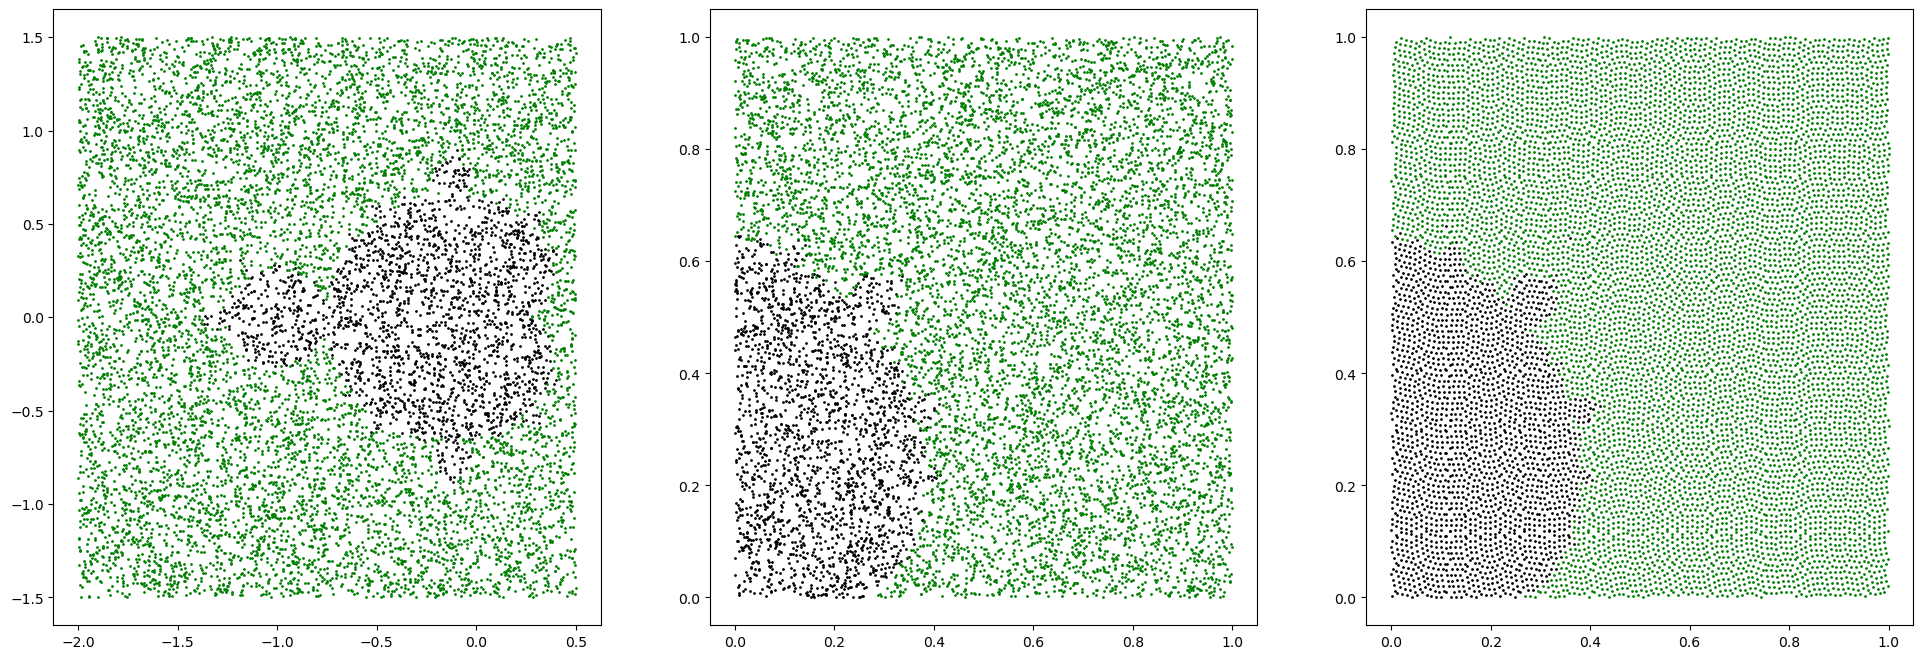

In [10]:
# PLotting

fig, ax = plt.subplots(1,3, figsize=(24,8))
for i, type in enumerate([random_sample, latin_sample, ortho_sample]):
    ax[i].plot([z.real for z in type[Ms[i]]], [z.imag for z in type[Ms[i]]], 'ko', markersize =1)
    ax[i].plot([z.real for z in type[~Ms[i]]], [z.imag for z in type[~Ms[i]]], 'go', markersize =1)
